## Image Segmentation

In [1]:
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import cv2
import sys

from ImageSegmentation import *

In [2]:
TRAIN_DATA = "/Users/apil.tamang/kaggle_cervical_cancer_code/download/train"
ADD_DATA = "/Users/apil.tamang/kaggle_cervical_cancer_code/download/additional"
SAVE_IMG_PATH = '/Users/apil.tamang/kaggle_cervical_cancer_code/segmented_src/train'
VALID_DATA = '/Users/apil.tamang/kaggle_cervical_cancer_code/download/valid'

In [3]:
def getType_1_2_3_ids(train_path):
    print("looking for images in: ", train_path)
    type_1_files = glob(os.path.join(train_path, "Type_1", "*.jpg"))
    type_1_ids = np.array([s[len(os.path.join(train_path, "Type_1")) + 1:-4] for s in type_1_files])
    type_2_files = glob(os.path.join(train_path, "Type_2", "*.jpg"))
    type_2_ids = np.array([s[len(os.path.join(train_path, "Type_2")) + 1:-4] for s in type_2_files])
    type_3_files = glob(os.path.join(train_path, "Type_3", "*.jpg"))
    type_3_ids = np.array([s[len(os.path.join(train_path, "Type_3")) + 1:-4] for s in type_3_files])

    # do this because Type_1 failed at around 75%
#   type_1_ids = type_1_ids[890:]
#   type_2_ids = type_2_ids[:5]
#   type_3_ids = type_3_ids[:5]
    
    return type_1_ids, type_2_ids, type_3_ids

def crop(img,y_min,y_max, x_min, x_max):
    return img[y_min:y_max,x_min:x_max]

def save_croppedImage(image_id, image_type, DATA_ROOT, img):
    data_path = os.path.join(DATA_ROOT, image_type)
    ext = 'jpg'
    img_path = os.path.join(data_path, "{}.{}".format(image_id, ext))
    cv2.imwrite(img_path, img)

In [9]:
def process_image_and_save_segmented_data(train_path, SAVE_IMG_PATH, type_ids_list, image_type="TRAIN"):
    for k, type_ids in enumerate(type_ids_list):
        m = len(type_ids)
        train_ids = sorted(type_ids)
        counter = 0

        for i in range(m):
            image_id = train_ids[counter]
            try:
                
                counter += 1

                if image_type=="TRAIN":
                    img = get_image_data(image_id, 'Type_%i' % (k + 1), train_path)
                else:
                    img = get_image_data(image_id, 'unknown', train_path)

                if img is None:
                    continue
                img = cropCircle(img)
                img_copy = img.copy()

                w = img.shape[0]
                h = img.shape[1]

                imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);

                # Saturating the a-channel at 150 helps avoiding wrong segmentation
                # in the case of close-up cervix pictures where the bloody os is falsly segemented as the cervix.
                Ra = Ra_space(img, 1.0, 150)
                a_channel = np.reshape(Ra[:, 1], (w, h))
                plt.subplot(121)
                plt.imshow(a_channel)

                g = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0, init_params='kmeans')
                image_array_sample = shuffle(Ra, random_state=0)[:1000]
                g.fit(image_array_sample)
                labels = g.predict(Ra)
                labels += 1  # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.

                # The cluster that has the highest a-mean is selected.
                labels_2D = np.reshape(labels, (w, h))
                gg_labels_regions = measure.regionprops(labels_2D, intensity_image=a_channel)
                gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
                cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

                mask = np.zeros((w * h, 1), 'uint8')
                mask[labels == cervix_cluster] = 255
                mask_2D = np.reshape(mask, (w, h))

                cc_labels = measure.label(mask_2D, background=0)
                regions = measure.regionprops(cc_labels)
                areas = [prop.area for prop in regions]

                regions_label = [prop.label for prop in regions]
                largestCC_label = regions_label[areas.index(max(areas))]
                mask_largestCC = np.zeros((w, h), 'uint8')
                mask_largestCC[cc_labels == largestCC_label] = 255

                img_masked = img.copy()
                img_masked[mask_largestCC == 0] = (0, 0, 0)
                img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY);

                _, thresh_mask = cv2.threshold(img_masked_gray, 0, 255, 0)

                kernel = np.ones((11, 11), np.uint8)
                thresh_mask = cv2.dilate(thresh_mask, kernel, iterations=1)
                thresh_mask = cv2.erode(thresh_mask, kernel, iterations=2)
                _, contours_mask, _ = cv2.findContours(thresh_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

                main_contour = sorted(contours_mask, key=cv2.contourArea, reverse=True)[0]

                x, y, w, h = cv2.boundingRect(main_contour)

                # comment out the drawing of the rectangle
                # cv2.rectangle(img, (x, y), (x + w, y + h), 255, 2)
                # plt.subplot(122)
                # plt.imshow(img)
                #plt.show()
                img = crop(img_copy, y, y+h, x, x+w) 
                img = cv2.resize(img, dsize=(224, 224))

                if image_type=="TRAIN":
                    save_croppedImage(image_id, 'Type_%i' % (k + 1), SAVE_IMG_PATH, img)
                else:
                    save_croppedImage(image_id, 'unknown', SAVE_IMG_PATH, img)

                frac = int(float(counter)/m * 100.)," %"
                sys.stdout.write("progress: %s  \r" % (str(frac)))
                sys.stdout.flush()
            except:
                print("error processing image: ", image_id, '. Type_%i' % (k + 1), " on path: ", train_path )

In [5]:
# process image in the train and add directory in download/
# for train_path in [TRAIN_PATH, ADD_DATA]:
#     print("data in: ", train_path)
    
#     all_type_ids = getType_1_2_3_ids(train_path)
#     process_image_and_save_segmented_data(train_path, SAVE_IMG_PATH, all_type_ids)

In [10]:
# process image in only the training set
TEST_PATH = "/Users/apil.tamang/kaggle_cervical_cancer_code/download/test"
test_files = glob(os.path.join(TEST_PATH, "unknown", "*.jpg"))
test_ids = np.array([s[len(os.path.join(TEST_PATH, "unknown")) + 1:-4] for s in test_files])
SAVE_TEST_IMG_PATH = '/Users/apil.tamang/kaggle_cervical_cancer_code/segmented_src/test'


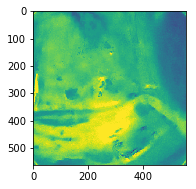

In [11]:
process_image_and_save_segmented_data(TEST_PATH, SAVE_TEST_IMG_PATH, [test_ids], image_type="TEST")